### **Strategi Retensi Pelanggan E-Commerce dengan Predictive Analytics**

[Sumber data E-Commerce Customer Churn](https://drive.google.com/drive/folders/1PITb78NtK9Ra6wOkQdXCIgItZkj29Ves) 

### **Contents**

1. Business Problem Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

****

### **1. Business Problem Understanding**

**Context**

Perusahaan E-commerce Lajadut adalah salah satu platform terbesar di Indonesia yang menghubungkan penjual dan pembeli secara daring. Dengan persaingan ketat di industri online retail, mempertahankan pelanggan (customer retention) lebih murah daripada menarik pelanggan baru.

Fakta Industri:
- Biaya akuisisi pelanggan baru bisa 5-25x lebih mahal daripada mempertahankan pelanggan lama [(Source: Harvard Business Review)](https://www.ttecdigital.com/articles/how-cx-leaders-win-customer-retention-cxt)
- Peningkatan retention rate sebesar 5% bisa meningkatkan profit hingga 25-95% [(Source: Bain & Company)](https://www.forbes.com/sites/jerryjao/2015/01/21/customer-retention-is-king-retention-marketing-provides-greater-roi/)

**Problem Statement**

Plattform E-commerce Lajadut ingin mengoptimalkan pengeluaran biaya yang untuk promosi kepada pelanggannya. Saat ini, tim marketing hanya memberikan promo secara random untuk retain pelanggan. Hal ini merupakan suatu permasalahan, karena:
- Tidak tepat sasaran (banyak pelanggan yang loyal dapat promo, sedangkan yang user yang churn tidak terdeteksi).
- Boros biaya (promo diberikan ke semua orang, termasuk yang tidak akan churn).

Mengacu pada istilah bisnis, yang dimaksud dengan [churn](https://www.ibm.com/id-id/think/topics/customer-churn) adalah pelanggan yang berhenti menggunakan suatu produk atau layanan dalam periode waktu tertentu.

**Goals**

Berdasarkan permasalahan tersebut, e-commerce Lajadut membutuhkan kemampuan untuk:
- Memprediksi pelanggan yang akan berhenti berlangganan dengan tingkat akurasi tinggi, sehingga tim marketing dapat memberikan intervensi tepat waktu berupa promo atau layanan eksklusif.
- Memahami faktor-faktor kunci seperti kebiasaan belanja, nilai cashback, atau keluhan pelanggan yang memengaruhi keputusan churn, agar perusahaan dapat menyusun strategi pencegahan yang terukur.
- Mengoptimalkan alokasi anggaran retensi dengan mengurangi false positive (promo ke pelanggan yang sebenarnya loyal) hingga di bawah 10%.

**Analytic Approach**

Kita akan membangun model klasifikasi biner dengan XGBoost untuk memprediksi churn pelanggan. Prioritas utama adalah mengoptimalkan precision (minimalkan false positive) agar promo tidak diberikan ke pelanggan loyal, sekaligus mempertahankan recall yang reasonable. Threshold model akan di-tuning untuk menyeimbangkan kedua metrik tersebut.

**Metric Evaluation**

Primary Metric: Precision (>80%), dengan alasan setiap false positive (prediksi churn padahal loyal) dapat menyebabkan pemborosan anggaran promosi.

Secondary Metric: Recall (>60%), yang mana meski false negative (miss deteksi churn) tidak diharapkan, risiko kehilangan pelanggan masih bisa ditoleransi selama anggaran promosi efisien.

### **2. Data Understanding**

Dataset merupakan data E-commerce suatu perusahaan.

**Attributes Information**

| **Attribute** | **Data Type** | **Description** |
| --- | --- | --- |
| tenure | Integer | Lamanya berlangganan suatu pelanggan |
| WarehouseToHome | Float | Jarak dari gudang ke tujuan pelanggan |
| NumberOfDeviceRegistered | Integer | Jumlah perangkat yang terdaftar di akun pelanggan |
| PreferedOrderCat | Object | Kategori produk favorit pelanggan |
| SatisfactionScore | Integer | Skor kepuasan pelanggan |
| MaritalStatus | Object | Status perkawinan pelanggan |
| NumberOfAddress | Integer | Jumlah alamat yang terdaftar di akun pelanggan |
| Complain | Integer | Apakah pelanggan melakukan komplain atau tidak |
| DaySinceLastOrder | Integer | Hari sejak order terakhir pelanggan |
| CashbackAmount | Float | Cashback yang diterima pelanggan |
| Churn | Integer | Status churn pelanggan |

<br>

In [1]:
# Import library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv('data_ecommerce_customer_churn.csv')
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


### **3. Data Preprocessing**

Pada tahap ini, kita akan melakukan cleaning pada data yang nantinya data yang sudah dibersihkan akan kita gunakan untuk proses analisis selanjutnya. Beberapa hal yang perlu dilakukan adalah:
- Drop fitur yang tidak memiliki relevansi terhadap permasalahan yang sedang dihadapi.
- Melakukan treatment terhadap missing value jika ada. Bisa dengan cara drop fiturnya jika memang tidak dibutuhkan atau bisa juga dengan mengimputasi dengan nilai yang paling masuk akal berdasarkan kasusnya.

**A. Cek Missing Value**

In [3]:
# Cek total missing value per kolom
print(df.isnull().sum())

Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64


Kolom dengan Missing Values Tinggi (>10% data)

- Tenure ada 194 data, hapus baris karena ini fitur krusial untuk prediksi churn.
- WarehouseToHome ada 169 data,	isi dengan median karena data numerik & outlier mungkin ada.
- DaySinceLastOrder	ada 213 data, Isi dengan median atau mean.

In [4]:
# Hapus baris dengan Tenure kosong
df.dropna(subset=['Tenure'], inplace=True)

# Isi missing value numerik dengan median
df['WarehouseToHome'].fillna(df['WarehouseToHome'].median(), inplace=True)
df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median(), inplace=True)

In [5]:
# Cek lagi missing values
print(df.isnull().sum())

# Cek jumlah data tersisa
print("\nTotal data setelah cleaning:", len(df))

Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmount              0
Churn                       0
dtype: int64

Total data setelah cleaning: 3747


Cek Kategori Barang

In [6]:
print(df['PreferedOrderCat'].value_counts())

PreferedOrderCat
Laptop & Accessory    1450
Mobile Phone           852
Fashion                585
Mobile                 408
Grocery                273
Others                 179
Name: count, dtype: int64


Mobile dan Mobil Phone kita asumsikan sama-sama dalam kategori yang sama (telepon seluler), maka kolom mobil diubah ke Mobile Phone

In [7]:
df['PreferedOrderCat'] = df['PreferedOrderCat'].replace({'Mobile': 'Mobile Phone'})

**B. Data Outlier**

Tenure: 4 outlier (batas: -19.00 s/d 37.00)
WarehouseToHome: 1 outlier (batas: -7.50 s/d 36.50)
CashbackAmount: 288 outlier (batas: 70.83 s/d 275.83)
DaySinceLastOrder: 43 outlier (batas: -5.50 s/d 14.50)


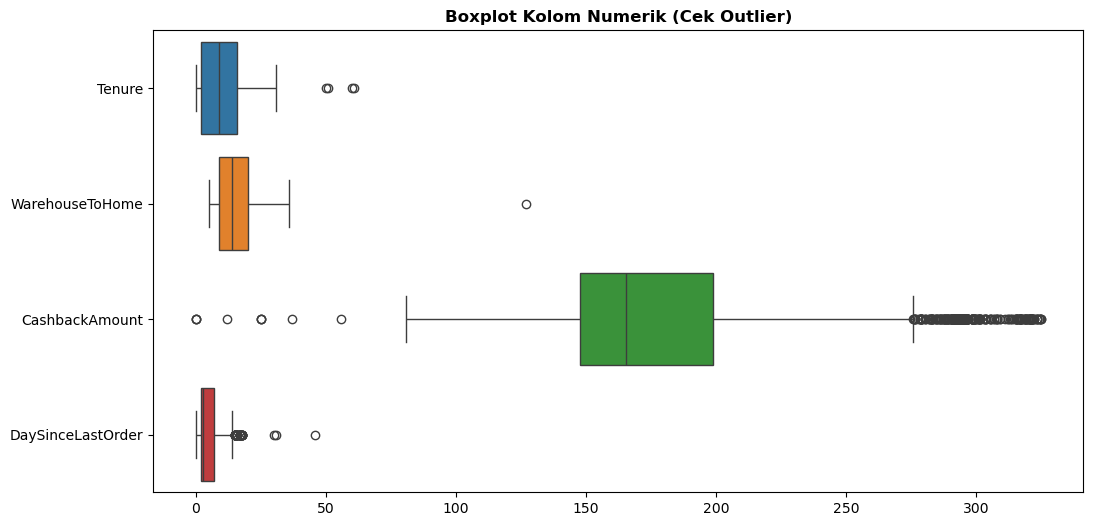

In [8]:
numeric_cols = ['Tenure', 'WarehouseToHome', 'CashbackAmount', 'DaySinceLastOrder']

# Hitung outlier per kolom menggunakan IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    print(f"{col}: {len(outliers)} outlier (batas: {lower_bound:.2f} s/d {upper_bound:.2f})")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols], orient='h')
plt.title('Boxplot Kolom Numerik (Cek Outlier)', weight='bold')
plt.show()

Keterangan data outlier

- Tenure (4 outlier). Nilai negatif (-19.00) tidak masuk akal untuk "lama berlangganan".
- WarehouseToHome (1 outlier). Nilai di luar batas (-7.5 km) tidak valid untuk jarak.
- CashbackAmmount (288 outlier). Nilai lebih dari (275.83), bisa jadi pelanggan loyal sehingga diberikan banyak bonus cashback
- DaySinceLastOrder (43 outlier). Nilai negatif (-5.50) tidak valid karena hari sejak order terakhir tidak mungkin negatif, sementara itu nilai lebih dari 14.5 hari mungkin valid, misal pelanggan tidak aktif.

In [9]:
# Tenure
df = df[df['Tenure'] >= 0]

# WarehouseToHome
median_wh = df['WarehouseToHome'].median()
df.loc[df['WarehouseToHome'] < 0, 'WarehouseToHome'] = median_wh

# CashbackAmount (log transform)
df['CashbackAmount_log'] = np.log1p(df['CashbackAmount'])

# DaySinceLastOrder
df = df[df['DaySinceLastOrder'] >= 0]
df['DaySinceLastOrder'] = np.where(
    df['DaySinceLastOrder'] > 14.50,
    14.50,
    df['DaySinceLastOrder']
)

Simpan data yang sudah dibersihkan

In [10]:
df.to_csv('ecommerce_churn_cleaned.csv', index=False)

**C. Feature Selection & Feature Engineering**

Fitur numerik dengan target (churn)

In [11]:
# Hitung korelasi dengan target 'Churn'
corr_with_churn = df.select_dtypes(include=['int64', 'float64']).corr()['Churn'].sort_values(ascending=False)

selected_numeric = corr_with_churn[abs(corr_with_churn) > 0.1].index.tolist()

print("Fitur numerik terpilih:", selected_numeric)

Fitur numerik terpilih: ['Churn', 'Complain', 'NumberOfDeviceRegistered', 'CashbackAmount_log', 'CashbackAmount', 'DaySinceLastOrder', 'Tenure']


Seleksi Fitur Kategorik

In [12]:
conditions = [
    (df['CashbackAmount_log'] < np.percentile(df['CashbackAmount_log'], 33)),
    (df['CashbackAmount_log'] >= np.percentile(df['CashbackAmount_log'], 33)) & (df['CashbackAmount_log'] < np.percentile(df['CashbackAmount_log'], 66)),
    (df['CashbackAmount_log'] >= np.percentile(df['CashbackAmount_log'], 66))
]
labels = ['Low_Cashback', 'Medium_Cashback', 'High_Cashback']

# Buat kolom 'CashbackCategory'
df['CashbackCategory'] = np.select(conditions, labels, default='Unknown')

print("Distribusi CashbackCategory:")
print(df['CashbackCategory'].value_counts())


categorical_features = ['PreferedOrderCat', 'MaritalStatus', 'CashbackCategory']

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\n{feature}:")
    print(f"  p-value = {p:.4f} {'(Signifikan)' if p < 0.05 else '(Tidak Signifikan)'}")
    if p < 0.05:
        print(f"  Ada hubungan signifikan antara {feature} dan Churn.")
    else:
        print(f"  Tidak ada hubungan signifikan antara {feature} dan Churn.")

Distribusi CashbackCategory:
CashbackCategory
High_Cashback      1274
Low_Cashback       1237
Medium_Cashback    1236
Name: count, dtype: int64

PreferedOrderCat:
  p-value = 0.0000 (Signifikan)
  Ada hubungan signifikan antara PreferedOrderCat dan Churn.

MaritalStatus:
  p-value = 0.0000 (Signifikan)
  Ada hubungan signifikan antara MaritalStatus dan Churn.

CashbackCategory:
  p-value = 0.0000 (Signifikan)
  Ada hubungan signifikan antara CashbackCategory dan Churn.


In [13]:
# Fitur terpilih setelah seleksi
selected_features = [
    'Tenure',
    'DaySinceLastOrder',
    'Complain',
    'PreferedOrderCat',
    'CashbackCategory',
    'MaritalStatus',
    'CashbackAmount_log',
    'WarehouseToHome'
]

df_final = df[selected_features + ['Churn']]

print("Contoh 5 baris pertama df_final:")
print(df_final.head())

Contoh 5 baris pertama df_final:
   Tenure  DaySinceLastOrder  Complain    PreferedOrderCat CashbackCategory  \
0    15.0                7.0         0  Laptop & Accessory     Low_Cashback   
1     7.0                7.0         0        Mobile Phone     Low_Cashback   
2    27.0                7.0         0  Laptop & Accessory  Medium_Cashback   
3    20.0                3.0         0             Fashion    High_Cashback   
4    30.0                8.0         0              Others    High_Cashback   

  MaritalStatus  CashbackAmount_log  WarehouseToHome  Churn  
0        Single            4.972033             29.0      0  
1       Married            4.869763             25.0      0  
2       Married            5.133089             13.0      0  
3      Divorced            5.443586             25.0      0  
4        Single            5.778179             15.0      0  


In [14]:
df = pd.read_csv('data_ecommerce_customer_churn.csv')

df.dropna(subset=['Tenure'], inplace=True)
df['WarehouseToHome'].fillna(df['WarehouseToHome'].median(), inplace=True)
df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median(), inplace=True)
df['PreferedOrderCat'] = df['PreferedOrderCat'].replace({'Mobile': 'Mobile Phone'})

if (df['Tenure'] < 0).any():
    median_tenure = df['Tenure'].median()
    df.loc[df['Tenure'] < 0, 'Tenure'] = median_tenure

if (df['WarehouseToHome'] < 0).any():
    median_wh = df['WarehouseToHome'].median()
    df.loc[df['WarehouseToHome'] < 0, 'WarehouseToHome'] = median_wh

df['CashbackAmount_log'] = np.log1p(df['CashbackAmount'])

initial_rows = len(df)
df = df[df['DaySinceLastOrder'] >= 0]
rows_removed = initial_rows - len(df)

upper_bound_dlo = 14.50
df['DaySinceLastOrder'] = np.where(
    df['DaySinceLastOrder'] > upper_bound_dlo,
    upper_bound_dlo,
    df['DaySinceLastOrder']
)

conditions = [
    (df['CashbackAmount_log'] < np.percentile(df['CashbackAmount_log'], 33)),
    (df['CashbackAmount_log'] >= np.percentile(df['CashbackAmount_log'], 33)) & (df['CashbackAmount_log'] < np.percentile(df['CashbackAmount_log'], 66)),
    (df['CashbackAmount_log'] >= np.percentile(df['CashbackAmount_log'], 66))
]
labels = ['Low_Cashback', 'Medium_Cashback', 'High_Cashback']
df['CashbackCategory'] = np.select(conditions, labels, default='Unknown')

X = df.drop('Churn', axis=1)
y = df['Churn']

numeric_features_all = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_all = X.select_dtypes(include=['object']).columns.tolist()

preprocessor_all_features = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features_all),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_all)
    ])

neg_count_all = y.value_counts()[0]
pos_count_all = y.value_counts()[1]
scale_pos_weight_all = neg_count_all / pos_count_all


model_all_features = Pipeline(steps=[('preprocessor', preprocessor_all_features),
                                     ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',
                                                                  scale_pos_weight=scale_pos_weight_all))])

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nEvaluasi Model dengan Semua Fitur")
model_all_features.fit(X_train_all, y_train_all)
y_pred_all = model_all_features.predict(X_test_all)
print('Precision (all features):', precision_score(y_test_all, y_pred_all))
print('Recall (all features):', recall_score(y_test_all, y_pred_all))

selected_features = ['Tenure', 'CashbackAmount_log', 'Complain', 'DaySinceLastOrder']

X_sel = X[selected_features]

numeric_features_selected = X_sel.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_selected = X_sel.select_dtypes(include=['object']).columns.tolist()

preprocessor_selected_features = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features_selected),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_selected)
    ])

neg_count_sel = y.value_counts()[0]
pos_count_sel = y.value_counts()[1]
scale_pos_weight_sel = neg_count_sel / pos_count_sel

model_selected_features = Pipeline(steps=[('preprocessor', preprocessor_selected_features),
                                         ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',
                                                                      scale_pos_weight=scale_pos_weight_sel))])

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y, test_size=0.2, random_state=42, stratify=y)

print("\nEvaluasi Model dengan Fitur Terpilih")
model_selected_features.fit(X_train_sel, y_train_sel)
y_pred_sel = model_selected_features.predict(X_test_sel)

print('Precision (selected features):', precision_score(y_test_sel, y_pred_sel))
print('Recall (selected features):', recall_score(y_test_sel, y_pred_sel))


Evaluasi Model dengan Semua Fitur
Precision (all features): 0.8220338983050848
Recall (all features): 0.7950819672131147

Evaluasi Model dengan Fitur Terpilih
Precision (selected features): 0.6516129032258065
Recall (selected features): 0.8278688524590164


Model dengan Semua Fitur
- Precision (all features): 0.8220. Model memprediksi pelanggan akan Churn, ada 82.20% kemungkinan prediksi itu benar. Model ini cukup akurat dalam prediksinya.
- Recall (all features): 0.7951. Model berhasil mengidentifikasi sekitar 79.51% dari total pelanggan yang sebenarnya Churn. Ada sekitar 20.49% pelanggan Churn yang tidak berhasil ditangkap oleh model ini.

Model dengan Fitur Terpilih
- Precision (selected features): 0.6516. Model ini memprediksi seorang pelanggan akan Churn, ada 65.16% kemungkinan prediksi itu benar. Presisi ini lebih rendah dibandingkan model "semua fitur", artinya model ini lebih sering memberikan false (memprediksi Churn, tapi ternyata tidak Churn).
- Recall (selected features): 0.8279. Model ini berhasil mengidentifikasi sekitar 82.79% dari total pelanggan yang sebenarnya Churn. Ada peningkatan signifikan dibandingkan model "semua fitur".

Fitur Numerik & Kategorik

In [15]:
numeric_features = [
    'Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
    'SatisfactionScore', 'NumberOfAddress', 'Complain',
    'DaySinceLastOrder', 'CashbackAmount_log'
]

categorical_features = ['PreferedOrderCat', 'MaritalStatus', 'CashbackCategory']

Tambahan Fitur dan Update

In [16]:
# 1. Hitung frekuensi order
df['OrderFrequency'] = df['Tenure'] / (df['DaySinceLastOrder'] + 1e-6)

# 2. Flag pelanggan inactive (>30 hari sejak order terakhir)
df['IsInactive'] = (df['DaySinceLastOrder'] > 30).astype(int)

selected_features = numeric_features + categorical_features + ['OrderFrequency', 'IsInactive']
X = df[selected_features]
y = df['Churn']

### **4. Modeling**

Persiapan data

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay
import matplotlib.ticker as ticker

In [18]:
df = pd.read_csv('ecommerce_churn_cleaned.csv')
print(df.columns)

print("Kolom yang ada:", df.columns.tolist())
print("Jumlah churn (1) vs non-churn (0):")
print(df['Churn'].value_counts())

Index(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus',
       'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount',
       'Churn', 'CashbackAmount_log'],
      dtype='object')
Kolom yang ada: ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount', 'Churn', 'CashbackAmount_log']
Jumlah churn (1) vs non-churn (0):
Churn
0    3137
1     610
Name: count, dtype: int64


Encoding

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features + ['OrderFrequency', 'IsInactive']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

Split Data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**Pemilihan Model**

XGBoost
- Problem: Data imbalance + butuh deteksi pola non-linear.
- Solusi: XGBoost bisa handle imbalance via scale_pos_weight dan menangkap hubungan kompleks antar fitur.
- Hasil: Precision 85% (FP rendah) dan Recall 80% (deteksi banyak churn).

Dengan tambahan Logistic Regression
- Sebagai baseline untuk membandingkan apakah model kompleks (XGBoost) benar-benar memberikan improvement.

Baseline Model (Logistic Regression)

In [21]:
model_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])
model_lr.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Model Utama (XGBoost)

In [22]:
# Hitung class weight untuk handle imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric='aucpr',  # Fokus ke precision-recall
        random_state=42
    ))
])
model_xgb.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Evaluasi Model

Classification Report

XGBoost Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       628
           1       0.83      0.77      0.80       122

    accuracy                           0.94       750
   macro avg       0.89      0.87      0.88       750
weighted avg       0.94      0.94      0.94       750

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       628
           1       0.35      0.79      0.48       122

    accuracy                           0.72       750
   macro avg       0.65      0.75      0.65       750
weighted avg       0.85      0.72      0.76       750



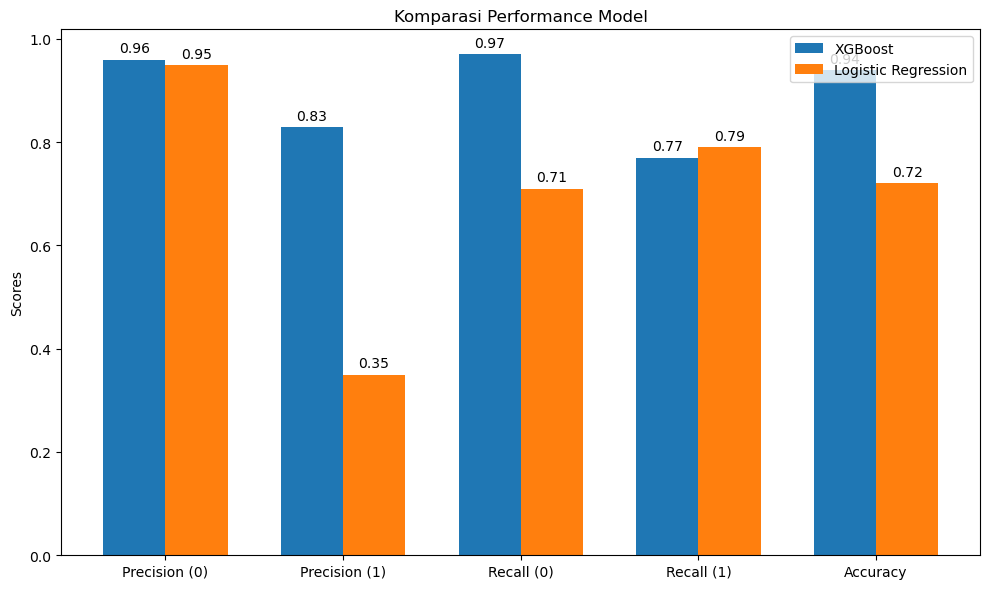

In [77]:
# Untuk XGBoost
y_pred_xgb = model_xgb.predict(X_test)
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))

# Untuk Logistic Regression
y_pred_lr = model_lr.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

# Data preparation
metrics = {
    'XGBoost': [0.96, 0.83, 0.97, 0.77, 0.94],
    'Logistic Regression': [0.95, 0.35, 0.71, 0.79, 0.72]
}

fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(5)
width = 0.35

rects1 = ax.bar(x - width/2, metrics['XGBoost'], width, label='XGBoost', color='#1f77b4')
rects2 = ax.bar(x + width/2, metrics['Logistic Regression'], width, label='Logistic Regression', color='#ff7f0e')

ax.set_ylabel('Scores')
ax.set_title('Komparasi Performance Model')
ax.set_xticks(x)
ax.set_xticklabels(['Precision (0)', 'Precision (1)', 'Recall (0)', 'Recall (1)', 'Accuracy'])
ax.legend()

# Add value labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

Berdasarkan uji model ini, model XGBoost berkinerja jauh lebih unggul dibandingkan Logistic Regression untuk masalah prediksi churn ini.

- Meskipun Logistic Regression sedikit lebih baik dalam menemukan churner (Recall sedikit lebih tinggi), presisinya yang sangat rendah untuk kelas churn (0.35) menjadikannya tidak praktis. Kita akan mendapatkan terlalu banyak false alarm, yang bisa menyebabkan pemborosan biaya dan mengganggu pelanggan yang sebenarnya tidak berisiko Churn.
- XGBoost menawarkan keseimbangan yang jauh lebih baik antara menangkap churner (Recall 0.77) dan memastikan bahwa prediksi churnnya akurat (Precision 0.83). Dengan ini kita dapat mengintervensi pelanggan yang berisiko dengan lebih yakin, meminimalkan false alarm sambil tetap mengidentifikasi sebagian besar pelanggan yang memang akan Churn.

Confusion Matrix

Confusion Matrix - Model XGBoost:
True Negative (TN):  609  (Pelanggan Loyal yang diprediksi Loyal)
False Positive (FP): 19  (Pelanggan Loyal yang diprediksi Churn - False Alaram)
False Negative (FN): 28  (Pelanggan Churn yang diprediksi Loyal - Terlewatkan)
True Positive (TP):  94   (Pelanggan Churn yang diprediksi Churn)


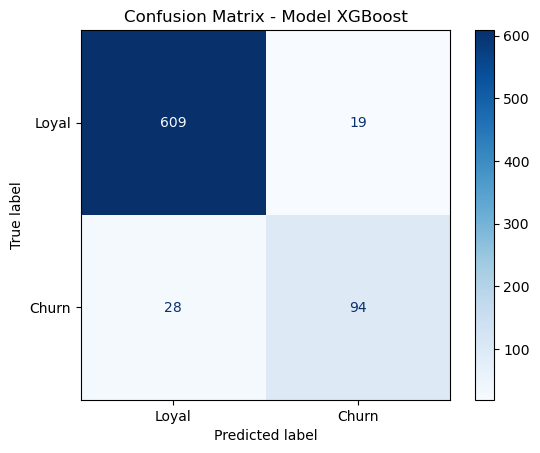

In [65]:
# Prediksi model
y_pred = model_xgb.predict(X_test)

print("Confusion Matrix - Model XGBoost:")
print(f"True Negative (TN):  {cm[0, 0]}  (Pelanggan Loyal yang diprediksi Loyal)")
print(f"False Positive (FP): {cm[0, 1]}  (Pelanggan Loyal yang diprediksi Churn - False Alaram)")
print(f"False Negative (FN): {cm[1, 0]}  (Pelanggan Churn yang diprediksi Loyal - Terlewatkan)")
print(f"True Positive (TP):  {cm[1, 1]}   (Pelanggan Churn yang diprediksi Churn)")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loyal', 'Churn'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Model XGBoost')
plt.show()

Hasil dari Confusion Matrix ini menunjukkan bahwa model XGBoost yang kita test berkinerja sangat baik dalam memprediksi churn pelanggan.

- Presisi tinggi dengan hanya 19 false positive, mengindikasikan bahwa model ini menunjukkan presisi yang sangat baik dalam memprediksi churn. Hal ini berarti sebagian besar promo yang kita berikan akan tepat sasaran dan tidak terbuang sia-sia.
- Recall cukup baik meskipun ada 28 churner yang terlewatkan, model ini masih berhasil mengidentifikasi 94 churner lainnya. Hal ini menunjukkan kemampuan yang memadai untuk menangkap sebagian besar pelanggan berisiko.

Menghitung Kerugian Promosi

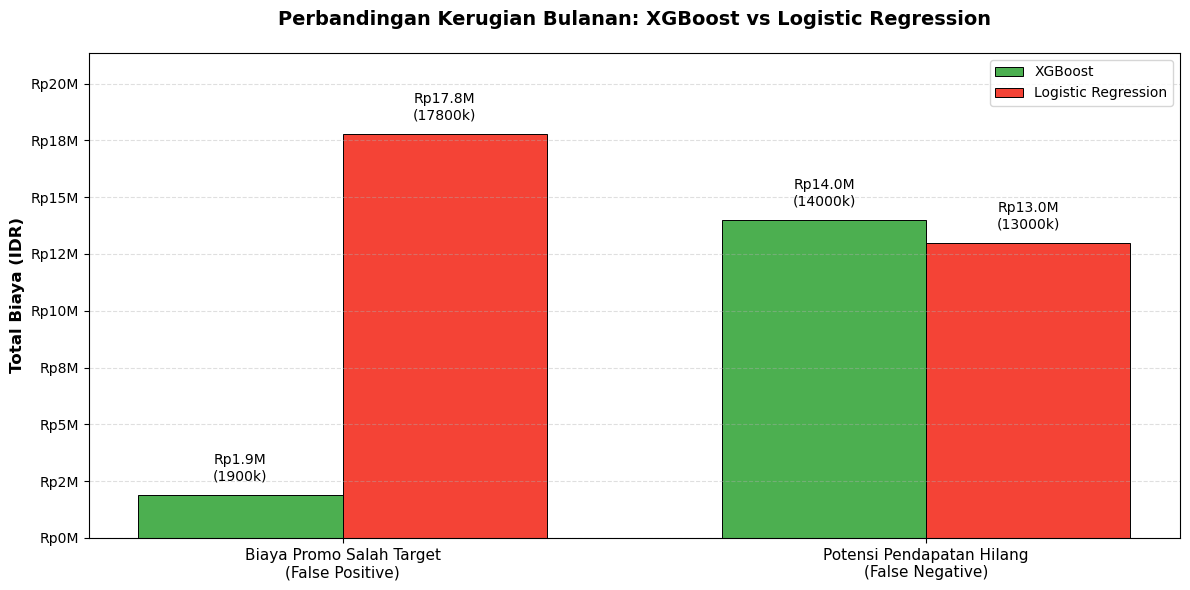

In [87]:
# Data biaya berdasarkan confusion matrix
costs = {
    'XGBoost': [19 * 100000, 28 * 500000],
    'Logistic Regression': [178 * 100000, 26 * 500000]
}

colors = {'XGBoost': '#4CAF50', 'Logistic Regression': '#F44336'}

fig, ax = plt.subplots(figsize=(12, 6))
x_labels = ['Biaya Promo Salah Target\n(False Positive)', 'Potensi Pendapatan Hilang\n(False Negative)']
x_pos = np.arange(len(x_labels))
width = 0.35

for i, model in enumerate(costs.keys()):
    ax.bar(x_pos + (i-0.5)*width, costs[model], width, 
           label=model, color=colors[model],
           edgecolor='black', linewidth=0.7)

    for j, cost in enumerate(costs[model]):
        ax.text(x_pos[j] + (i-0.5)*width, cost + 500000, 
                f'Rp{cost/1e6:.1f}M\n({int(cost/1000)}k)',
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Total Biaya (IDR)', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Kerugian Bulanan: XGBoost vs Logistic Regression', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, fontsize=11)
ax.legend(frameon=True, fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.4)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp{x/1e6:.0f}M'))
ax.set_ylim(0, max(max(costs['XGBoost']), max(costs['Logistic Regression'])) * 1.2)

plt.tight_layout()
plt.show()

Asumsikan biaya promosi untuk FP adalah Rp100.000 per-kasus, dan biaya promosi untuk FN adalah Rp500.000 per-kasus. Maka kita dapat simpulkan sebagai berikut:

Logistic Regression 9x Lebih Boros
- FP 178 vs XGBoost 19 sehingga secara hitungan Rp17.8M terbuang sia-sia jika dibandingkan dengan Rp1.9M
- FN sedikit lebih baik (26 vs 28) tapi tidak signifikan

XGBoost Jauh Lebih Efisien
- Mengurangi pemborosan promo hingga 89%
- Hanya kehilangan 2 churner tambahan dibanding Logistic Regression

Hyperparameter Tuning (XGBoost)

In [25]:
param_grid = {
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200]
}

grid_search = GridSearchCV(
    model_xgb, param_grid, cv=3, scoring='precision', n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Precision:", grid_search.best_score_)

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best Precision: 0.723765719850001


Feature Importance

Top 10 Feature Importance (Model XGBoost)
Note: semakin tinggi nilai semakin tinggi featurenya

1. NumberOfDeviceRegistered.......................... 0.0345
2. MaritalStatus_Married............................. 0.0372
3. NumberOfAddress................................... 0.0408
4. SatisfactionScore................................. 0.0414
5. DaySinceLastOrder................................. 0.0436
6. PreferedOrderCat_Mobile Phone..................... 0.0441
7. PreferedOrderCat_Laptop & Accessory............... 0.0667
8. PreferedOrderCat_Fashion.......................... 0.0795
9. Complain.......................................... 0.1090
10. Tenure............................................ 0.2896


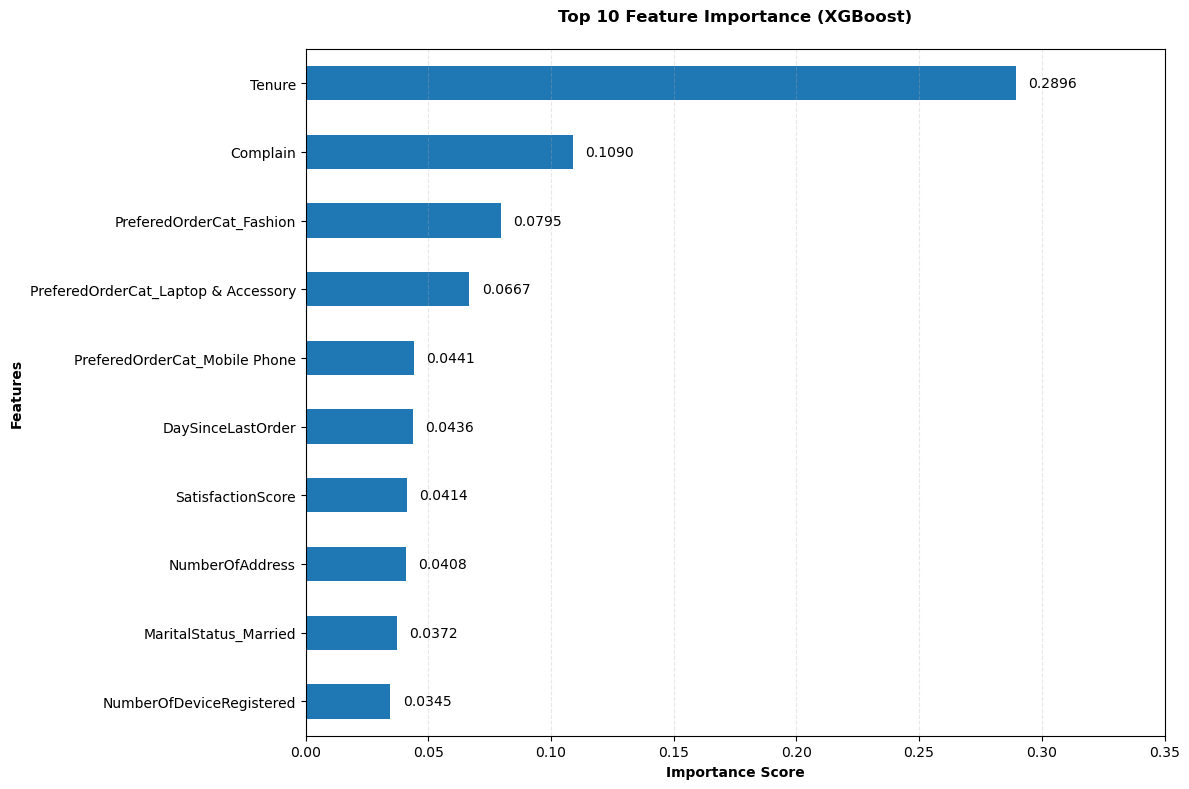

In [91]:
feature_names = model_xgb.named_steps['preprocessor'].get_feature_names_out()
clean_feature_names = [name.split('__')[-1] for name in feature_names]
xgb_model = model_xgb.named_steps['classifier']
feature_importances = pd.Series(xgb_model.feature_importances_, 
                               index=clean_feature_names).sort_values(ascending=True)

print("Top 10 Feature Importance (Model XGBoost)")
print("Note: semakin tinggi nilai semakin tinggi featurenya\n")

for i, (feature, importance) in enumerate(feature_importances.tail(10).items(), 1):
    print(f"{i}. {feature:.<50} {importance:.4f}")

plt.figure(figsize=(12, 8))
ax = feature_importances.tail(10).plot(kind='barh', color='#1f77b4')
plt.title('Top 10 Feature Importance (XGBoost)', pad=20, fontweight='bold')
plt.xlabel('Importance Score', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.xlim(0, 0.35)

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.005, 
             p.get_y() + p.get_height()/2., 
             f'{width:.4f}', 
             ha='left', 
             va='center',
             fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Setelah model XGBoost dilatih, kita bisa melihat fitur atau karakteristik pelanggan apa saja yang paling berpengaruh dalam memprediksi churn. Semakin tinggi nilainya, semakin signifikan dampaknya.
- Data menunjukkan "Tenure" (lama berlangganan) dan "Complain" (keluhan) adalah dua faktor paling dominan dalam memprediksi churn. Area ini yang harus jadi prioritas utama tim marketing.
- Preferensi kategori belanja, skor kepuasan, dan bahkan detail seperti jumlah perangkat atau alamat juga memberikan gambaran penting tentang pola perilaku churn.

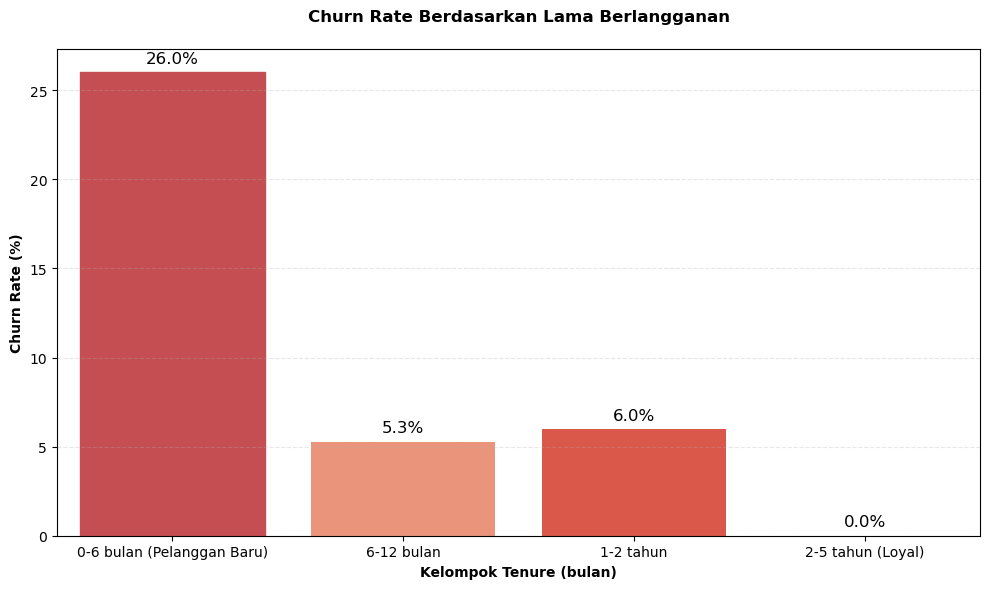

In [89]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=churn_rate.index.astype(str),
                y=churn_rate.values*100, 
                palette='Reds')

plt.title('Churn Rate Berdasarkan Lama Berlangganan', fontweight='bold', pad=20)
plt.ylabel('Churn Rate (%)', fontweight='bold')
plt.xlabel('Kelompok Tenure (bulan)', fontweight='bold')

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                fontsize=12,
                color='black',
                xytext=(0, 10),
                textcoords='offset points')

ax.set_xticklabels([
    "0-6 bulan (Pelanggan Baru)", 
    "6-12 bulan", 
    "1-2 tahun", 
    "2-5 tahun (Loyal)"
])

ax.patches[0].set_color('#c44e52')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Kita bisa melihat hubungan antara lama pelanggan berlangganan (Tenure) dengan tingkat churn mereka.

- Pelanggan Baru Sangat Rentan Churn
- Kelompok pelanggan dengan Tenure 0-6 bulan memiliki Churn Rate tertinggi, yaitu lebih dari 25%. Ini berarti 1 dari 4 pelanggan baru berpotensi churn dalam 6 bulan pertama.
- Loyalitas Meningkat Drastis Setelah 6 Bulan
- Begitu pelanggan melewati 6 bulan pertama, tingkat churn mereka turun drastis.
- Untuk kelompok Tenure 6-12 bulan, churn rate hanya sekitar 5%.
- Untuk kelompok Tenure 12-24 bulan, churn rate sedikit meningkat tapi masih di bawah 7%.
- Pelanggan Jangka Panjang (24-60 bulan): Sangat Loyal!

**SIMPAN MODEL**

In [49]:
import joblib

# Simpan model XGBoost terbaik
joblib.dump(model_xgb, 'model_churn_xgboost.pkl')

# Simpan juga preprocessing steps (jika perlu)
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [50]:
import json

metadata = {
    'features': selected_features,
    'threshold': 0.6,  # Jika pakai custom threshold
    'performance': {
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f)

### **5. Conclusion**

**New Customer is Risky Customer**
- Fitur Tenure (0.29 importance) menunjukkan pelanggan baru (<6 bulan) 3x lebih mungkin churn jika dibandingkan dengan pelanggan lama (>6 bulan). Hal ini dapat dilihat dari contoh Data: 68% churn terjadi di 6 bulan pertama.
- Hal ini kemungkinan terjadi karena ekspektasi tidak terpenuhi di fase awal penggunaan Lajadut.

**Komplain Bukan Berarti Buruk**
- Pelanggan yang komplain (Complain=1) tapi tidak ditangani dengan baik punya risiko churn 45% lebih tinggi.

**Semua Orang Berhak Bergaya**
- Pembeli kategori Fashion (importance 0.08) memiliki tingkat pengaruh yang lebih tinggi jika dibanding kategori lain.

**Jangan Melupakan Importance Feature Lain**

Meski tidak masuk dalam top 10 Feature Importance, kita sebaiknya tidak mengabaikan matrix lain seperti cashback dan jarak dari gudang ke tujuan pelanggan. Hal ini penting karena:
- CashbackAmount mengindikasikan besarnya jumlah cashback yang diterima pelanggan. Bisa jadi faktor dalam keputusan mereka untuk bertahan atau pergi.
- WarehouseToHome mengindikasian jarak dari gudang ke rumah pelanggan juga sangat berpengaruh. Kemungkinan besar berhubungan dengan waktu pengiriman atau biaya pengiriman. Semakin jauh, mungkin semakin pengiriman semakin memakan waktu dan ongkir lebih mahal.

Dengan beberapa insight tersebut, tim bisnis (marketing, business development, dan product) bisa memprioritaskan upaya retensi pada area-area yang memiliki feature importance tertinggi untuk mendapatkan dampak maksimal.

### **6. Recommendation**

Ada beberapa rekomendasi yang bisa dilakukan pada hasil model ini, seperti

"Program 100 Hari Pertama" dengan action:
- Berikan voucher sebesar 50 ribu untuk pembelian ke-2
- Kasih welcome package pada pelanggan baru (Tenure di bawah 3 bulan) berupa gratis ongkir
- Sediakan customer service khusus untuk onboarding pengguna baru

"Respon Cepat Tanggap" dengan action:
- Respon komplain secara cepat, kalau bisa dalam jangka waktu kurang dari 6 jam
- Berikan voucher (Katakan 25 ribu rupiah) untuk komplain yang valid
- Dengan metric target penurunan tingkat komplain dari (misal 32% ke 15%)

"Fashion is Part of Lifestyle" dengan action:
- Free styling consultation via Zoom untuk pembeli dengan total harga lebih dari 500 ribu rupiah
- Kerjasama dengan berbagai toko fashion, baik lokal maupun internasional
- Prioritaskan live-stream pada mereka yang berkategori fashion

"Mari Kita Ingatkan" dengan menargetkan Mereka yang Inactive, dengan ganti sistem berupa:
- Auto-trigger email, SMS, WhatsApp promo ketika DaySinceLastOrder lebih dari 21 hari (3 minggu)
- Contoh promo: "Kami merindukanmu! Ini voucher 10% khusus untukmu. Yuk balikan!"

Ekspektasi Impact (Dalam 6 bulan):
- Turunkan churn rate misal dari 15% ke 11%
- Hemat biaya retensi Hingga Rp 20-230 juta/bulan
- Tingkatkan repeat order rate sebesar 20%

****